Задание

Подсчет объектов: круги, квадраты, треугольники, а также их вариации типа квадрат с треугольной дыркой или круг с двумя квадратными дырками. Классификация (ручная), сколько каждого класса. Например, подсчет суммы по монетам (они не перекрываются). В данной задаче рассматривается "идеальный" вариант: фон однотонный. Используются фильтры: сглаживание, пороговые, производная. Поиск контуров.

In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Функцией connectedComponentsWithStats

In [2]:
def get_holes(img_stats, count):
    left, top, wight, height, area = img_stats[2][count]
    complex_object = img_stats[1][top:top+height, left:left+wight]
    
    #инвертирование
    complex_object = complex_object == 5
    complex_object = np.uint8(1-complex_object)

    #обрезка фона
    mask = np.zeros((complex_object.shape[0]+2, complex_object.shape[1]+2), np.uint8)
    cv.floodFill( complex_object, mask, (0,0), 0)
    cv.floodFill( complex_object, mask, (complex_object.shape[0]-1, complex_object.shape[0]-1), 0)
    cv.floodFill( complex_object, mask, (complex_object.shape[0]-1, 0), 0)
    cv.floodFill( complex_object, mask, (0, complex_object.shape[0]-1), 0)

    #plt.imshow(complex_object, interpolation = 'none');
    cmpts_obj = cv.connectedComponentsWithStats(complex_object)
    if cmpts_obj[0] > 1:
        left1 = cmpts_obj[3][0][0] + left
        top1 = cmpts_obj[3][0][1] + top
        return ([left1, top1], cmpts_obj[2][0][4])
    else:
        return 'one'

In [3]:
def get_objects(img):
    cmptsStats = cv.connectedComponentsWithStats(img)
    len(cmptsStats), cmptsStats[0] # 0 индекс содержит количество компонент.
    if cmptsStats[0] > 1:
        #массив площадей
        ll = np.array([param[-1] for param in cmptsStats[2]])
        plt.imshow(img, interpolation='none');
        
        print()
        #выделение объектов при наличии шума
        centers = []
        classes = []
        border_noise = 4 #максимальная прощадь шумного объекта
        for object in np.where(ll > border_noise )[0]:
            check_hols = get_holes(cmptsStats, object)
            if check_hols != 'one':
                centers += [check_hols[0]]
                classes += [check_hols[1]]
            else:
                centers += [[*cmptsStats[3][object]]]    
                classes += [cmptsStats[2][object][4]]
        
        df = pd.DataFrame(np.array(centers[1:]), np.array(classes[1:]), columns=['x', 'y'])
        #df.plot.scatter(x='x', y='y', c=df.index)
        
        #отображение центроидов объектов       
        for pa in np.array(centers[1:]):
            plt.plot(*pa, '*')
        #plt.legend(classes[1:])
        
        count_class = dict()
        for clas in classes[1:]:
            count_class[clas] = count_class.get(clas, 0) + 1
        print(f'image has {len(classes[1:])} objects')  
        print(count_class)    
    else:
        print('no objects')

 простой пример

In [4]:
# Создаем изображение из целочисленных значений.
img_bin = np.zeros((200,200), 'uint8')


# Указывается изображение,Центр изображения, радиус,
# цвет (в случае бинарного изображения, соответственно, 1 или 0)
# толщину линии, -1 означает заполнить.
cv.circle( img_bin, (50, 60), 15, 1, -1);
cv.circle( img_bin, (150, 160), 13, 1, -1);
cv.circle( img_bin, (50, 180), 11, 1, -1);

# Отрисовываем прямоугольник.
# Указывается изображение,координаты противоположных уголов,
# цвет и толщину линии.
cv.rectangle( img_bin, (100, 50), (140, 30), 1, -1);

In [5]:
img = np.zeros((200,200), 'uint8')
get_objects(img)

no objects



image has 4 objects
{861: 1, 709: 1, 529: 1, 377: 1}


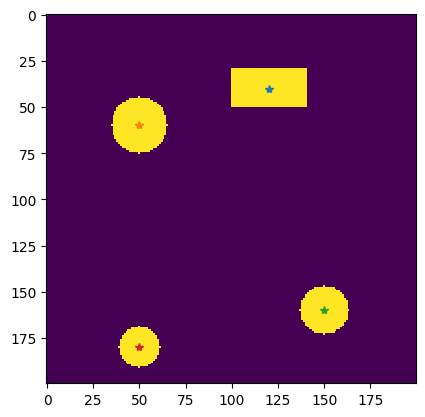

In [6]:
get_objects(img_bin)

с солью


image has 4 objects
{866: 1, 712: 1, 530: 1, 377: 1}


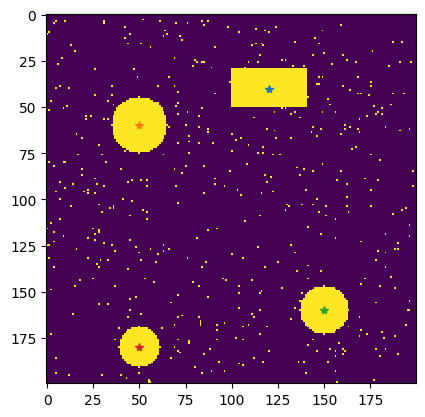

In [7]:
rng = np.random.default_rng(2021)
rng.integers(0, 5, 10)
coords = [rng.integers(0, i, int(500)) for i in img_bin.shape]

img_salt = img_bin.copy()
img_salt[tuple(coords)] = 1

get_objects(img_salt)

 Фигуры с дырками

In [8]:
img_bincp = img_bin.copy()
cv.rectangle( img_bincp, (100, 125), (102,127), 1, -1);
cv.circle( img_bincp, (48, 176), 3, 0, -1);
cv.circle( img_bincp, (48, 184), 3, 0, -1);
#get_objects(img_bincp)


image has 8 objects
{9: 2, 861: 1, 709: 1, 529: 2, 471: 1, 319: 1}


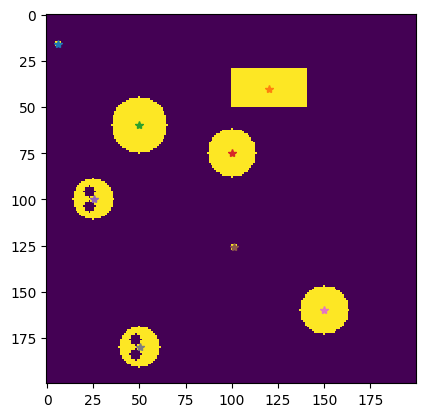

In [9]:
img_bincp2 = img_bincp.copy()
cv.rectangle( img_bincp2, (5, 15), (7,17), 1, -1); #маленький прямоугольник
cv.circle( img_bincp2, (100, 75), 13, 1, -1); #круг
cv.rectangle( img_bincp2, (100, 125), (102,127), 1, -1);
#круг с двумя дырками
cv.circle( img_bincp2, (25, 100), 11, 1, -1);
cv.circle( img_bincp2, (23, 96), 3, 0, -1);
cv.circle( img_bincp2, (23, 104), 3, 0, -1);
get_objects(img_bincp2)

# FIND CONTOURS

In [10]:
def check_childs(hierar, childs):
    next_elem = hierar[childs[-1]][0]
    if next_elem == -1:
        return childs
    else:
        childs = check_childs(hierar, [*childs, next_elem])
        return childs


def get_child_coeff(objects_with_childs, cnts):
    x = []
    y = []
    parents = []
    for family in objects_with_childs:
        parent = family[0]
        parent_x = cnts[parent].reshape(cnts[parent].shape[0], 2).T[0].min()
        parent_y = cnts[parent].reshape(cnts[parent].shape[0], 2).T[1].min()
        
        parents += [parent]

        child_x = []
        child_y = []
        for elem in range(len(family[1])):
            child = family[1][elem]
            
            child_x += [cnts[child].reshape(cnts[child].shape[0], 2).T[0].min()]
            child_y += [cnts[child].reshape(cnts[child].shape[0], 2).T[1].min()]
            
        x += [parent_x - sum(child_x)/len(child_x)]
        y += [parent_y - sum(child_y)/len(child_y)]
        
    return parents, np.array(y) - np.array(x)    


def get_contours(img):
    (cnts, hierarchy) = cv.findContours(img.copy(), cv.RETR_CCOMP, cv.CHAIN_APPROX_TC89_L1)

    value_count = 0 #количество объектов на картинке
    objects_with_childs = [] #объекты с дырками
    objects_without_childs = [] #объекты без дырок
    cont_points_areas = [] #количество точек в контуре и площадь

    #составление список с детьми, без них и точек с площадьми
    for elem in range(len(hierarchy[0])):
        next, last, child, parent = hierarchy[0][elem]
        cont_points_areas += [f'{len(cnts[elem])}_{cv.contourArea(cnts[elem])}']
        
        if child != -1: # есть дети
            objects_with_childs += [[elem, check_childs(hierarchy[0], [child])]]
        if child == -1 and parent == -1:
            objects_without_childs += [elem]
    
    #расчет коэффициентов для объектов с дырками
    parents, coeffic = get_child_coeff(objects_with_childs, cnts)
    
    objects_without_childs = objects_without_childs + parents
    
    #обновление списка точек_площадей с учетом коэффициентов
    for coeff, elem in zip(coeffic, parents):
        cont_points_areas[elem] = cont_points_areas[elem]+'_'+str(coeff)
    
    #подсчет объектов
    count_class = dict()
    for obj in objects_without_childs:
        count_class[cont_points_areas[obj]] = count_class.get(cont_points_areas[obj], 0) + 1

    #преобразование картинки в RGB
    new_img = []
    for i in img:
        new_row = []
        for j in i:
            if j == 0:
                new_row += [[0,0,0]]
            if j == 1:
                new_row += [[65, 105, 225]]
        new_img += [new_row]
    new_img = np.array(new_img)
    
    #отрисовка контуров и подписей
    for obj in objects_without_childs:
        epsilon = 0.008 * cv.arcLength(cnts[obj], True)
        approximations = cv.approxPolyDP(cnts[obj], epsilon, True)
        i, j = approximations[0][0]
        cv.putText(new_img, f"{','.join(cont_points_areas[obj].split('_')[1:])}", (i+5, j-3), cv.FONT_HERSHEY_COMPLEX, 0.4, (255, 160, 122), 1)
        cv.drawContours(new_img, [approximations], 0, (1), 1)
        
    print(f'image has {len(objects_without_childs)} objects')
    print(count_class)
    plt.imshow(new_img);


Добавление на изображение повернутого прямоугольника и треугольника

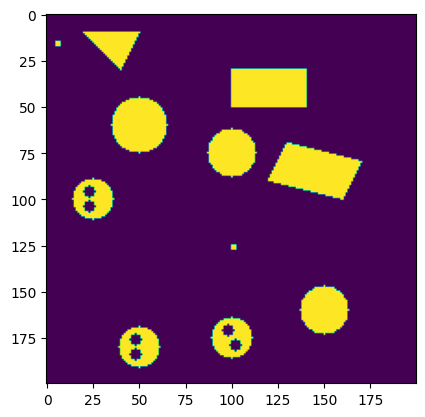

In [13]:
img_bincp3 = img_bincp2.copy()

points_triangle = np.array([[20, 10], [50, 10], [40, 30]])
cv.fillPoly(img_bincp3, pts=[points_triangle], color=1) #треугольник

#points_rectangle = np.array([[120, 70], [120, 90], [160, 90], [160, 70]])
points_rectangle = np.array([[130, 70], [120, 90], [160, 100], [170, 80]])
cv.fillPoly(img_bincp3, pts=[points_rectangle], color=1) #прямоугольник с поворотом

#круг с двумя дырками
cv.circle( img_bincp3, (100, 175), 11, 1, -1);
cv.circle( img_bincp3, (98, 171), 3, 0, -1);
cv.circle( img_bincp3, (102, 179), 3, 0, -1);
plt.imshow(img_bincp3)

image has 11 objects
{'20_516.0': 2, '4_4.0': 2, '28_902.0': 1, '20_690.0': 1, '4_800.0': 1, '5_300.0': 1, '20_362.0_-2.0': 2, '20_362.0_0.0': 1}


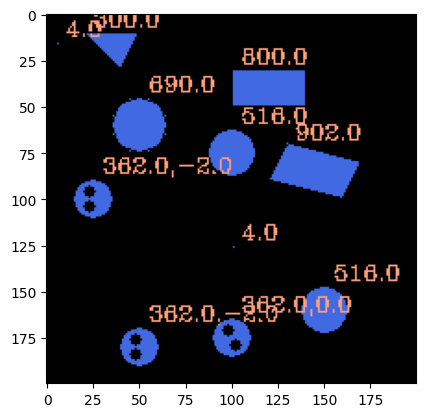

In [14]:
get_contours(img_bincp3)